In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import json

users = pd.read_csv("../database/users.csv")
students_profile = pd.read_csv("../database/students_profile.csv")
content = pd.read_csv("../database/content_items.csv")
interactions = pd.read_csv("../database/interactions.csv")

In [ ]:
def expand_skills(row):
    try:
        return pd.Series(json.loads(row))
    except:
        return pd.Series({})

skills_df = students_profile["skills_mastery"].apply(expand_skills)
skills_df = pd.concat([students_profile[["user_id"]], skills_df], axis=1)

# Merge user + skill data
merged_users = users.merge(skills_df, left_on="id", right_on="user_id", how="left")
merged_users.drop(columns=["user_id"], inplace=True)

# Merge interactions with user and content data
merged = interactions.merge(merged_users, left_on="user_id", right_on="id", how="left")
merged = merged.merge(content[["id", "difficulty"]], left_on="item_id", right_on="id", suffixes=('', '_content'))

# Clean up and fill missing values
merged.drop(columns=["response_text", "timestamp", "action", "id_content"], inplace=True, errors='ignore')
merged['correct'] = merged['correct'].astype(int)
merged.fillna(0, inplace=True)

In [22]:
# Helper to encode only if column exists
def safe_encode(df, col):
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes
    else:
        print(f"⚠️ Column '{col}' not found — skipped encoding.")

safe_encode(merged, 'preferences')
safe_encode(merged, 'goal')
safe_encode(merged, 'difficulty')

In [23]:
# Start with guaranteed features
base_features = ['time_taken', 'difficulty']

# Add optional ones only if they exist
optional_features = [f for f in ['stream', 'year_of_study', 'cgpa', 'career_goal'] if f in merged.columns]

# Add skill columns
skill_features = [c for c in skills_df.columns if c != 'user_id']

# Combine all
features = base_features + optional_features + skill_features
X = merged[features]
y = merged['correct']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=120, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [25]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.499

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51       455
           1       0.49      0.49      0.49       445

    accuracy                           0.50       900
   macro avg       0.50      0.50      0.50       900
weighted avg       0.50      0.50      0.50       900




Top 5 Important Features:
 time_taken       0.592329
difficulty       0.106156
Programming      0.045528
Communication    0.044056
Physics          0.043830
dtype: float64


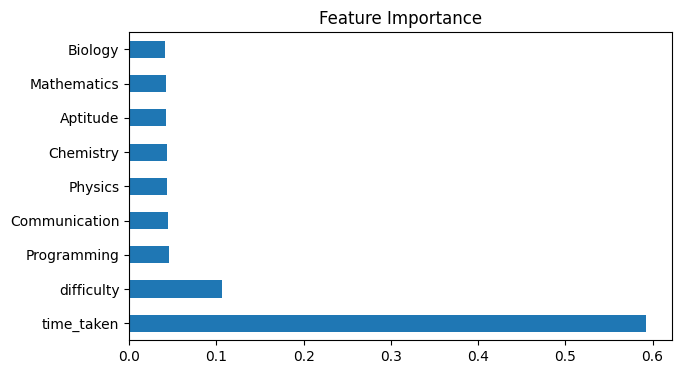

In [26]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 Important Features:\n", importances.head())

# Optional visualization
importances.head(10).plot(kind='barh', title='Feature Importance', figsize=(7,4))
plt.show()


In [27]:
sample = X.sample(1, random_state=42)
prediction = model.predict(sample)[0]
print("\nSample Prediction →", "Correct" if prediction == 1 else "Incorrect")



Sample Prediction → Incorrect
